# Project 3: Web APIs & NLP
by Ethan Leow


<div>
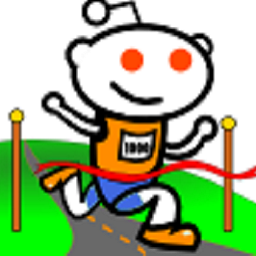
</div>

r/Ultramarathons: "Any idiot can run a marathon. It takes a special kind of idiot to run an ultramarathon."

r/AdvancedRunning: "Advanced Running: It's a mindset"



## Problem statement

I am a newbie to the marathon scene, having completed my first StanChart marathon virtually when the country was locked down during Covid-19 last year. I am itching to do my first ultramarathon (defined as any run beyond 42.195km) and have prepared a series of posts to ask running veterans for training advice. I found two of the most popular reddit communities for the ultra-running community to be r/Ultramarathon and r/AdvancedRunning. I want to find out where my posts would naturally belong to and elicit the most helpful comments. Their community descriptions are not helpful:
- r/Ultramarathon: Ultramarathon training, race reports, tips, tricks and overall discussion for crazy people who like ultrarunning.
- r/AdvancedRunning: Post here for discussion about training for running, race reports, elite results and discussion, and more. AR is NOT limited to a certain competitive level or race times. It is a mindset and the community is fueled by those who want to better themselves and talk to like minded competitors. The deciding factor is the type of training you are attempting to use to improve yourself. If the answer to the post is "run more miles" or "try speed work", then that question is more suitable in r/running.

A quick scan of their recent posts is also not helpful. Both communities have a lot of posts about how to train for 50k and beyond, as well as other miscellaneous items such as race reports. It is time to deploy my data science skills to come up with an algorithm to decide which running community most suited for my questions...

## Executive summary

## Import Libraries

In [1]:
# Import libraries
import time, warnings, requests
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Scrap reddit

### Create scrapper function

In [2]:
# Create scrapper function

def scrape_subreddit(subreddit, numberofposts = 1_000):
    # Define pushshift's base URL
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Define columns i want to keep
    to_keep = ['subreddit','author','title','selftext','created_utc']
    
    # Set current time in UTC timestamp format
    df_time = int(datetime.timestamp(datetime.utcnow()))
    
    # Create empty dataframe for concating loop later on
    df = pd.DataFrame(columns = to_keep)
    df_length = len(df)
    
    # Create dataframe of posts
    while df_length < numberofposts:

        # Set params
        params = {
            'subreddit' : subreddit,
            'size' : 100,
            'before' : df_time
        }

        # Get request from pushshift.io
        res = requests.get(url, params)
    
        # Concat relevant .json data into dataframe
        df = pd.concat([
            df,
            pd.DataFrame(res.json()['data'])[to_keep]
        ], 
            axis = 0
        )
        
        # Clean data
        ##  1. drop empty posts
        df = df.loc[
            ((df['selftext'] != '') & (df['selftext'] != '[removed]')),
            :
        ].sort_values('created_utc', ascending = False)
        ##  2. drop duplicates by author with same text
        df = df.drop_duplicates(subset=['selftext', 'author'], keep = 'first').reset_index(drop=True)
        
        # Find earliest-dated post in dataframe
        df_time = df['created_utc'].min()
#         print(f"min time is {df_time}.")
        
        # Find current length of dataframe (
        df_length = len(df)
#         print(f"df length is {df_length}.")
       
        # Be a good citizen of scrapping world, don't overload pushshift server 
        time.sleep(1 + np.random.rand())
        
    return df[:numberofposts]
    
    

Describe scrapper function:
- Arguments to feed in are (subreddit, numberofposts)
    - "subreddit" is the name of the target subreddit
    - "numberofposts" is the number of good-quality reddit posts to extract, default value is set at 1_000
- Set size at 100 for each request for posts
- Dropping bad-quality posts:
    - I notice about 20% of the posts are pictures or videos of people running, with nothing written, i.e. '' in the 'selftext', so those are dropped
    - A number of posts seem to be advertisements, they are labeled "[removed]" in the 'selftext' columns, so those are dropped
    - I remove reposts by the same author just in case they are posted more than once
- I set a random sleep time of between 1 to 2 seconds to avoid getting blacklisted by server for repeat requests

### Scrap scrap scrap

In [3]:
%%time
# Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files
# Typically takes about 3-10 minutes for me to run, depending on internet connection

# set scrape parameters
subreddit1 = 'Ultramarathon'
subreddit2 = 'AdvancedRunning'
posts = 1_500

# scrape from subreddits
df1 = scrape_subreddit(subreddit1, posts)
df2 = scrape_subreddit(subreddit2, posts)

CPU times: user 3.45 s, sys: 205 ms, total: 3.65 s
Wall time: 6min 48s


In [4]:
df1

subreddit                author  \
0     Ultramarathon         ultracrockett   
1     Ultramarathon           laflame1738   
2     Ultramarathon       ghostbrainalpha   
3     Ultramarathon        ultratraileric   
4     Ultramarathon  Right_Dragonfruit_89   
...             ...                   ...   
1495  Ultramarathon                eflowb   
1496  Ultramarathon         kmjuniormint5   
1497  Ultramarathon                Simco_   
1498  Ultramarathon              felsea62   
1499  Ultramarathon         a_bearded_man   

                                                  title  \
0                                           Spartathlon   
1                          Advice before my first ultra   
2           Who is in better shape for a 100 mile race?   
3        Continuing training after 50k plan is finished   
4                         First endless mile in a month   
...                                                 ...   
1495             Big races other than WSER and Hardrock   
1496  (Ultra)Running Media that I have gathered over...   
1497  Western States lottery: 2.2% chance counting a...   
1498                          Weekly vertical gain goal   
1499     Finished my first Ultra - 50 miles in the bag!   

                                               selftext created_utc  
0     Spartathlon (246 km/153 miles) starts tomorrow...  1632428494  
1     I am a D3 runner who is finishing up there las...  1632405780  
2     Neither person is remotely close to being capa...  1632332323  
3     I am using a 50k plan that I have used in the ...  1632325532  
4     So I’ve recently stumbled upon David Goggins, ...  1632199728  
...                                                 ...         ...  
1495  As someone who just started running ultra's la...  1481312190  
1496  Let's do this thing! Round 3 of videos from 20...  1481238619  
1497  &gt; A total of 4,248 runners entered the lott...  1480984499  
1498  What would be a good ballpark weekly vertical ...  1479471150  
1499  I just became an official ultramarathoner befo...  1479411289  

[1500 rows x 5 columns]

In [5]:
df2

subreddit             author  \
0     AdvancedRunning     SlowTwitchLion   
1     AdvancedRunning         OutsideFly   
2     AdvancedRunning             eled34   
3     AdvancedRunning         tunetown44   
4     AdvancedRunning      itwasthadweeb   
...               ...                ...   
1495  AdvancedRunning  ArcanaKnightJoker   
1496  AdvancedRunning        truckthin24   
1497  AdvancedRunning            _Royalz   
1498  AdvancedRunning      NotAtTheTable   
1499  AdvancedRunning     coochiMaster69   

                                                  title  \
0                    Is 3:00 marathon realistic for me?   
1                       Straightening Pigeon-Toed Foot?   
2     Training Plan Advice - 6 weeks Until NYC Marathon   
3             Best long distance Relay Races in the US?   
4                             My 2020 Pandemic Marathon   
...                                                 ...   
1495  How to watch the NN Mission Marathon! Kipchoge...   
1496                               Marathon Time Trial!   
1497                                   10k to 5k effort   
1498  Oddly specific Pfitzinger half marathon plan q...   
1499                            Daniels Running Formula   

                                               selftext created_utc  
0     I’m currently training to run the New York Cit...  1632435749  
1     Both of my feet are pretty pigeon-toed, but my...  1632426817  
2     Hi all,\n\nI’ve been battling chronic calf iss...  1632424259  
3     Hey all, myself and a few friends (probably a ...  1632412716  
4     It's been about a year, but I wanted to share ...  1632411029  
...                                                 ...         ...  
1495  https://www.nnrunningteam.com/news/2021-04-08-...  1618697823  
1496  \### Race Information\n\n\* \*\*Name:\*\* Mara...  1618696178  
1497  So almost a week ago I ran a 10k race in 38:39...  1618685649  
1498  Hi guys,\n\nSo I’m doing the 12/47 pfitzinger ...  1618683833  
1499  I just came off a week long break post track s...  1618681910  

[1500 rows x 5 columns]

### Save files to .csv

In [6]:
# Check files that have empty posts or that are '[removed]' by reddit

In [7]:
df1.loc[((df1.selftext == '[removed]') | (df1.selftext == '')), :]

Empty DataFrame
Columns: [subreddit, author, title, selftext, created_utc]
Index: []

In [8]:
df2.loc[((df1.selftext == '[removed]') | (df2.selftext == '')), :]

Empty DataFrame
Columns: [subreddit, author, title, selftext, created_utc]
Index: []

In [9]:
# Check for reposts
df1.duplicated().sum(), df2.duplicated().sum()

(0, 0)

In [10]:
# Save files
df1.to_csv('../data/df1.csv', index = False)
df2.to_csv('../data/df2.csv', index = False)

## Exploratory data analysis

### Load data

In [11]:
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

### Check authors
The intent is to look for very prolific authors who might post so much to a subreddit community that a classification model might just innocently fit to a very small group of authors' writing style. 

In [13]:
# Rank authors by posts
df1.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

author
ultracrockett           25
coraythan               18
Simco_                  15
Hocojerry               13
UltraRunningKid         11
brian_stelter            9
bondom3417               9
chad311                  8
BlackBullet96            8
peco9                    8
FrankWestTheEngineer     7
Ecstatic_Length          7
Tchaps1993               7
MrDilkington1            7
pascalosti               6
clutchguy84              5
Chobo_Knows              5
livingStory1             5
mcdishy                  5
amblingsam               5
Name: selftext, dtype: int64

In [14]:
df2.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

author
brwalkernc             31
ruinawish              15
ejsfsc07               13
bigtechdroid           11
MechanicalTim           8
eled34                  7
Nayaa03                 7
RektorRicks             6
I_cut_my_own_jib        6
AutoModerator           6
mcninja29               6
NotTheTrueKing          5
MotivicRunner           5
EducationalTeaching     5
ABrooksBrother          5
melonlord44             5
_-Socrates-_            5
JadenCyjJN              5
ijonesco                5
ArcanaKnightJoker       4
Name: selftext, dtype: int64

It looks like there is no issue with overly-prolific authors on both subreddits. The author with the highest number of posts on r\Ultramarathon is ultracrockett with 25 posts and the author with the highest on r\AdvancedRunning is brwalkernc with 31 posts. They make up <=2% of their sample sets respectively. 

However, on r\AdvancedRunning, it looks like there is a AI-powered author named "AutoModerator". Let's take a closer look at its posts.

In [15]:
df2[df2['author'] == "AutoModerator"]

subreddit         author  \
7    AdvancedRunning  AutoModerator   
33   AdvancedRunning  AutoModerator   
53   AdvancedRunning  AutoModerator   
77   AdvancedRunning  AutoModerator   
240  AdvancedRunning  AutoModerator   
563  AdvancedRunning  AutoModerator   

                                                 title  \
7    Thursday General Discussion/Q&amp;A Thread for...   
33                                    Tuesday Shoesday   
53           The Weekly Rundown for September 20, 2021   
77           The Weekend Update for September 17, 2021   
240                Monthly Reflections for August 2021   
563                Monthly Reflections for August 2021   

                                              selftext  created_utc  
7    A place to ask questions that don't need their...   1632369671  
33   Do you have shoe reviews to share with the com...   1632240020  
53   The Weekly Rundown is the place to talk about ...   1632110472  
77   What's everyone up to on this weekend? Racing?...   1631851274  
240   Alas, a new month is on its way and thus we t...   1630382421  
563  Alas, a new month is on its way and thus we ta...   1627704078

It looks like 'AutoModerator' is a bot that automatically generates posts to keep readers interested on events happening in the running world. I shall drop its posts since we are interested in analysing human-generated posts only. These posts make up <0.5% of the sample set.